<a href="https://colab.research.google.com/github/EddyGiusepe/Overfitting_and_Regularization/blob/main/Regularization_for_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Overfitting e Regularização</h2>


Data Scientist: Dr.Eddy Giusepe Chirinos Isidro

# Regularization

Como temos percebido, quando treinamos Redes Neurais corremos o risco de fazer `OVERFITTING` aos Dados de Treinamento, o qual será traduzido em uma má performance de nosso modelo quando receba Dados que nunca haja visto (ou seja não haverá GENERALIZADO). A melhor maneira de saber se nosso modelo tem Overfitting é observando as Curvas de Treinamento (<font color="orange">ver o gráfico a seguir</font>).

Neste script vamos treinar uma `MLP` no Dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) para classificação de imagens em $10$ classes diferentes.

![](https://hidden.brutalk.com/wp-content/uploads/2021/02/1614208808_358_How-to-use-Learning-Curves-to-Diagnose-Machine-Learning-Model.png)

Usaremos a biblioteca `torchvision` para descarregar o Dataset. 

Este Dataset está formado por imagens em cor de baixa resolução, temos $50000$ imagens de Treinamento e $10000$ de teste. O objetivo é classificar em $10$ classes diferentes. Vejamos alguns exemplos:

In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

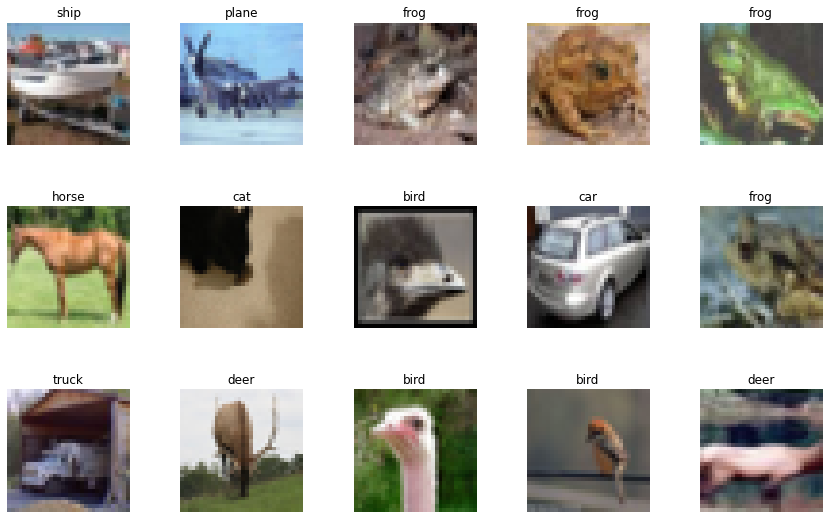

In [2]:
import random 
import matplotlib.pyplot as plt
%matplotlib inline

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

A seguir vamos a transformar as imagens em `arrays` de `NumPy` para poder trabalhar com elas mais facilmente.

In [3]:
import numpy as np


train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]


X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

Agora, podemos aplicar de forma similar o código para treinar um [The Multilayer Perceptron](https://github.com/EddyGiusepe/Perceptron_with_Python/blob/main/The_Multilayer_Perceptron_(MLP)_.ipynb), e assim poder observar as curvas de Treinamento.

In [4]:
import torch



class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [5]:
from sklearn.metrics import accuracy_score



def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()


def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [6]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.72114 acc 0.37301 val_loss 2.04510 val_acc 0.30210
Epoch 20/100 loss 1.49519 acc 0.45820 val_loss 3.31405 val_acc 0.22750
Epoch 30/100 loss 1.33193 acc 0.51354 val_loss 2.37751 val_acc 0.32000
Epoch 40/100 loss 1.18940 acc 0.56787 val_loss 3.16958 val_acc 0.30770
Epoch 50/100 loss 0.97756 acc 0.64550 val_loss 4.19273 val_acc 0.26540
Epoch 60/100 loss 0.84220 acc 0.70143 val_loss 3.81964 val_acc 0.28440
Epoch 70/100 loss 0.74415 acc 0.73129 val_loss 3.03989 val_acc 0.37410
Epoch 80/100 loss 0.61795 acc 0.78145 val_loss 3.84399 val_acc 0.30590
Epoch 90/100 loss 0.61594 acc 0.77408 val_loss 3.89622 val_acc 0.34920
Epoch 100/100 loss 1.38300 acc 0.59455 val_loss 3.51467 val_acc 0.33740


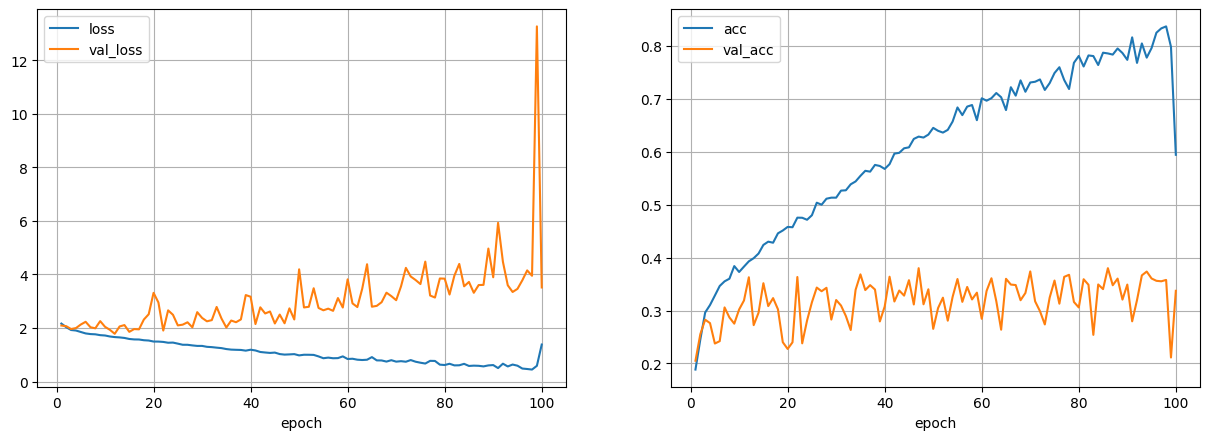

In [7]:
import pandas as pd

fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar nas curvas de Treinamento, as métricas para o conjunto de Dados de `Treinamento` vão melhorando epoch tras epoch, no entanto as métricas de `validação` rapidamente se estancam e começam a piorar. Isto é um sinal claro de que nosso Modelo está sofrendo de `Overfitting`.


Seguidamente estudaremos as diferentes técnicas de `REGULARIZAÇÃO`, o término técnico utilizado para referirmos às diferentes técnicas de redução de Overfitting.

# Regularização $L2$

Esta técnica é muito usada. Esta técnica consiste em penalizar (restringuir) a magnitude dos pesos da `Rede Neural`, forçando-os a ser valores pequenos. Para efeitos práticos, a `REGULARIZAÇÃO L2` se implementa como um término extra na Função de Perda, assim:


$$ l = CE(\hat{y}, y) + \alpha \frac{1}{2} || \mathbf{w} || $$


onde $CE(\hat{y}, y)$ é a função `Cross Entropy` (ou qualquer outra função de perda, dependendo da tarefa que estes realizando), $\mathbf{w}$ são os pesos da rede e $α$ é um parâmetro que indica quanto queremos regularizar o modelo. Em `Pytorch` podemos adicionar o valor de $α$ através do parâmetro `weight_decay` diretamente no otimizador (<font color="orange">por dafault é $0$</font>). Valores típicos usados estão no intervalo de $[0.001, 0.01]$. 

In [8]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.05)

Epoch 10/100 loss 2.08716 acc 0.22054 val_loss 2.32178 val_acc 0.12420
Epoch 20/100 loss 2.08258 acc 0.20621 val_loss 2.11870 val_acc 0.20920
Epoch 30/100 loss 2.08498 acc 0.22134 val_loss 2.13010 val_acc 0.18720
Epoch 40/100 loss 2.08579 acc 0.20760 val_loss 2.23992 val_acc 0.15450
Epoch 50/100 loss 2.07837 acc 0.21756 val_loss 2.20942 val_acc 0.16640
Epoch 60/100 loss 2.07586 acc 0.21994 val_loss 2.24086 val_acc 0.16680
Epoch 70/100 loss 2.09245 acc 0.19944 val_loss 2.06070 val_acc 0.24170
Epoch 80/100 loss 2.07647 acc 0.20780 val_loss 2.88530 val_acc 0.10340
Epoch 90/100 loss 2.08425 acc 0.20760 val_loss 2.16323 val_acc 0.17760
Epoch 100/100 loss 2.07860 acc 0.21139 val_loss 2.07367 val_acc 0.20180


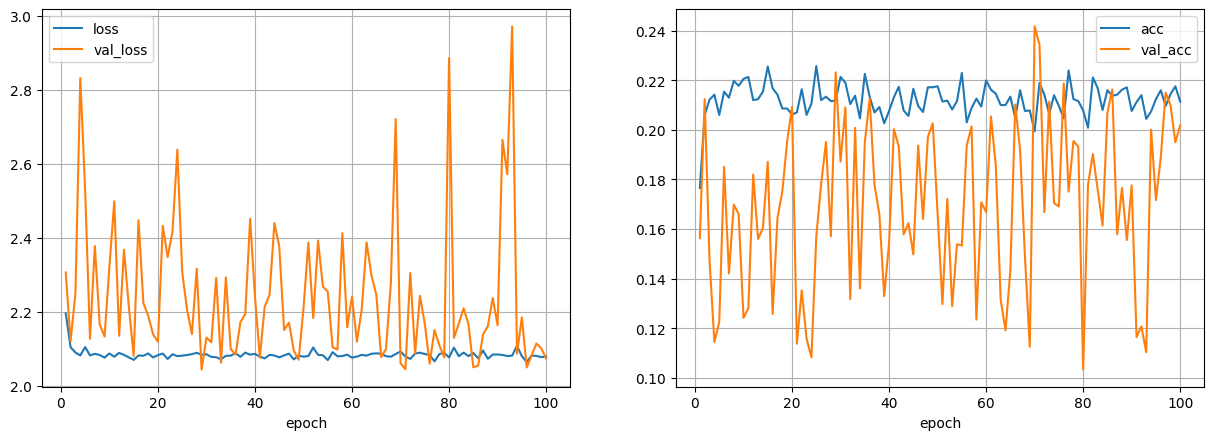

In [9]:
#fig = plt.figure(dpi=200, figsize=(10,3))
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

como podemo observar, agora, as curvas de Treinamento e Validação estão mais próximas (`as curvas Loss`), pelo que precebimos que conseguimos diminuir o Overfitting. <font color="orange">É importante dizer que reduzir o `Overfitting` não implica melhorar as métricas (o grafico de accuracy)</font>. 

# Early Stopping

Esta é outra técnica utilizada para regularizar um modelo. Esta técnica consiste em levar um registro das métricas de Validação durante o Treinamento, salvar os pesos do modelo cada vez que as métricas melhoram e, uma vez que termina o treinamento, carregar os melhores pesos invés de ficar com os últimos. De forma opcional também podemos deter o treinamento se em caso não melhora as nossas métricas durante um determinado número de epochs seguidas, o qual podemos traduzir numa economia de tempo e computo.

In [10]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [11]:
model = build_model()

hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.20500 en epoch 1
Mejor modelo guardado con acc 0.30460 en epoch 3
Mejor modelo guardado con acc 0.32370 en epoch 10
Epoch 10/100 loss 1.71281 acc 0.37938 val_loss 1.91328 val_acc 0.32370
Mejor modelo guardado con acc 0.32740 en epoch 11
Epoch 20/100 loss 1.50373 acc 0.44606 val_loss 2.35998 val_acc 0.26380
Entrenamiento detenido en epoch 21 por no mejorar en 10 epochs seguidas


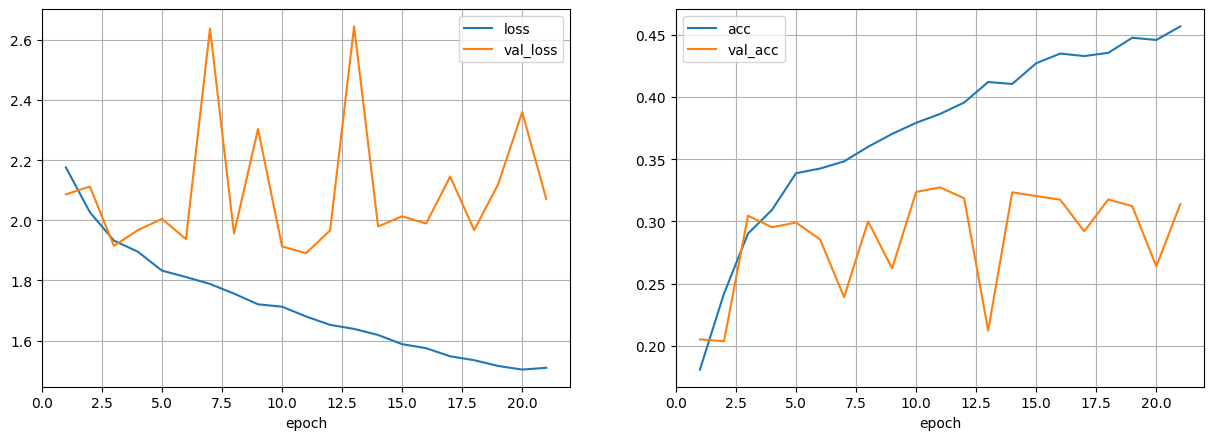

In [12]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Comparando esta figura com a primeira, podrás observar que se continuamos treinando com mais epochs não vamos obter um bom modelo. Por tanto, não é necessário seguir treinando, já que encontramos o melhor modelo possível dada as circustâncias. `Early Stopping` é uma técnica muito simples e efetiva, pelo que é recomendável usá-la sempre.  


> 💡 Dá uma olhada no `Pytorch`, para aprender a como salvar e carregar modelos [click aqui](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

# Dropout

Outra técnica muito popular para reduzir o `Overfitting` é o uso do `Dropout`. Esta técnica se implementa como uma camada extra a nossa Rede Neural cujo objetivo é, durante o Treinamento, "apagar" de maneira aleatória alguns neurônios de maneira que forçamos a nosso modelo a aprender diferentes caminhos dentro da arquitetura para representar os mesmos Dados. 

![](https://www.researchgate.net/profile/Yifan-Zhang-16/publication/332450026/figure/fig5/AS:748477176885249@1555462273508/Neural-network-with-dropout.png)

In [13]:
# Podemos ver a camada extra: "Dropout" 

def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

Podemos adicionar uma camada de Dropout com a classe `torch.nn.Dropout`. O parâmetro `p` controla a probabilidade de "apagar" uma neurona. Este valor coincide com a proporção (em promédio) de neuronas que serão anuladas numa camada determinada. 


> ⚡ Quando não estamos treinando, geralmente não desejamos que a capa Dropout esté ativa de maneira que utilicemos todas as  Neuronas no Modelo. Podemos controlar o modo como trabalha a camada chamando às funções `model.train()` e `model.eval()`, as quais serão responsáveis pela atribuição do modo adequado à camada Dropout (e qualquer outra camada de tua Rede que também tenha diferente comportamento segundo estemos Treinando ou Avaliando o Modelo). Isto é muito importante e fonte comum de erros ao trabalhar com `Pytorch`.

In [14]:
model = build_model(p=0.5)

hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.11180 en epoch 1
Mejor modelo guardado con acc 0.17050 en epoch 2
Mejor modelo guardado con acc 0.19620 en epoch 5
Mejor modelo guardado con acc 0.21100 en epoch 9
Epoch 10/100 loss 2.13378 acc 0.17576 val_loss 2.29364 val_acc 0.14030
Mejor modelo guardado con acc 0.22040 en epoch 14
Mejor modelo guardado con acc 0.22070 en epoch 16
Mejor modelo guardado con acc 0.23430 en epoch 17
Epoch 20/100 loss 2.07778 acc 0.20203 val_loss 2.02361 val_acc 0.22710
Mejor modelo guardado con acc 0.24650 en epoch 21
Mejor modelo guardado con acc 0.24720 en epoch 29
Mejor modelo guardado con acc 0.26770 en epoch 30
Epoch 30/100 loss 2.02792 acc 0.22711 val_loss 2.00978 val_acc 0.26770
Mejor modelo guardado con acc 0.27770 en epoch 34
Mejor modelo guardado con acc 0.27990 en epoch 39
Epoch 40/100 loss 1.99362 acc 0.25358 val_loss 2.01688 val_acc 0.24980
Mejor modelo guardado con acc 0.28280 en epoch 42
Epoch 50/100 loss 1.97239 acc 0.26592 val_loss 1.99171 val_acc 0.26320

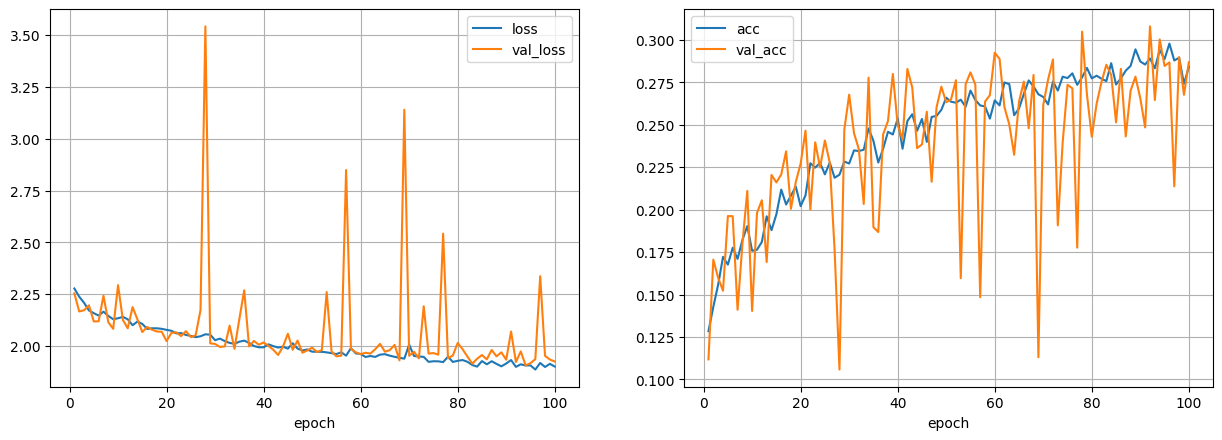

In [15]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Mais uma vez observamos que as curvas de Treinamento já não apresentam Overfitting. Podemos brincar um pouco com a Probabilidade de Dropout para controlar seu efeito no resultado final. De novo, reparemos que reduzir o Overfitting não implica necessariamente que nosso modelo tenha melhores métricas, simplesmente estamos forçando ao modelo a não `aprender a memorizar` o Dataset de treinamento.

# Usar mais Dados

A melhor maneira de reduzir o Overfitting é usando mais Dados. Isto é um fato obvio, mas não é simples de conseguir já que obter um maior Dataset não é sempre fatível e geralmente sempre usamos todos os Dados que temos a nossa disposição. No entanto, a diferença do resto de estrategias apresentadas até agora, ésta não só reduzirá o Overfitting senão que também melhorará as métricas de nosso modelo.

In [16]:
# Agora sim que usamos todos os Dados

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [17]:
model = build_model()

hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.34390 en epoch 1
Mejor modelo guardado con acc 0.35410 en epoch 2
Mejor modelo guardado con acc 0.40220 en epoch 3
Mejor modelo guardado con acc 0.42120 en epoch 4
Mejor modelo guardado con acc 0.44490 en epoch 6
Mejor modelo guardado con acc 0.44760 en epoch 9
Mejor modelo guardado con acc 0.44840 en epoch 10
Epoch 10/100 loss 1.49157 acc 0.46468 val_loss 1.57974 val_acc 0.44840
Mejor modelo guardado con acc 0.45430 en epoch 12
Mejor modelo guardado con acc 0.47240 en epoch 13
Epoch 20/100 loss 1.38097 acc 0.50128 val_loss 1.56861 val_acc 0.44790
Entrenamiento detenido en epoch 23 por no mejorar en 10 epochs seguidas


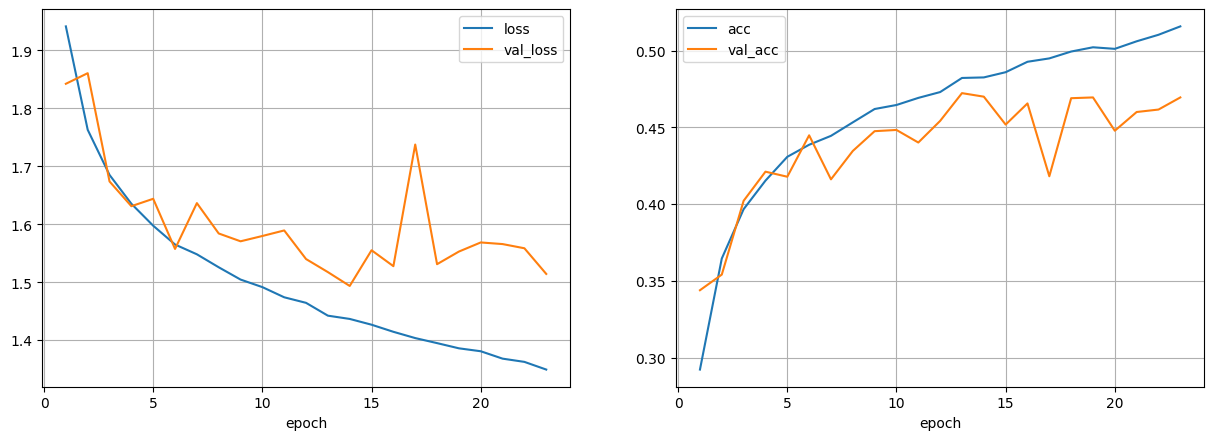

In [18]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar a métrica de nosso modelo se a incrementado consideravelmente graças ao uso de mais Dados. Desta maneira aproveitamos mais a capacidade do modelo.

# Data Augmentation

Como não sempre é fácil conseguir mais Dados, podemos aplicar a seguinte ideia: invés de fornecer ao modelo sempre nossas imagens na mesma maneira, vamos aplicar transformações de maneira aleatória de forma que, efetivamente, nosso modelo não veja nunca a mesma imagem duas vezes, conseguindo assim um Dataset potencialmente infinito. Estas transformações devem alterar a imagem o suficiente como para poder considerá-la como uma amostra diferente mas não muito como para alterar sua etiqueta. Alguns exemplos destas transformações incluem: `giros`, `recortes`, `alterações de cor`, `brilho` ou `tamanho`, etc.

Existem muitas ferramentas disponíveis para aplicar transformações a imagens (por exemplo a mesma biblioteca de `torchvision` inclue algumas). Uma eleção popular é a biblioteca [albumentations](https://github.com/albumentations-team/albumentations).

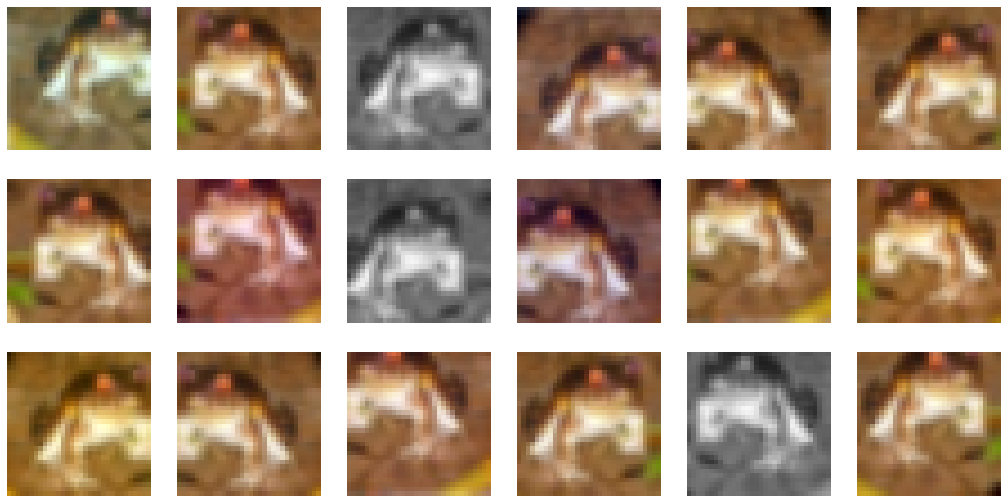

In [19]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Na figura anterior estamos visualizando uma única amostra de nosso Dataset à qual aplicamos uma série de transformações que tem alterado sua apariência sem modificar sua Label (etiqueta). Aplicando éstas transformações aleatórias a cada amostra antes de fornecer à `Red Neuronal` obrigará a nosso modelo a GENERALIZAR muito mais, reduzindo o Overfitting. 

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [ ]:
model = build_model()

hist = fit(model, dataloader)

In [ ]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

O uso de Data Augmentation requer de um Treinamento mais longo para poder aproveitar toda a capacidade que as TRANSFORMAÇÕES nos oferece. Uma característica interessante desta técnica é que podemos conseguir que as curvas de aprendizagem de Validação estém por acima das de treinamento, indicando que nosso modelo realmente trabalha melhor em Dados não vistos (o qual não significa necessariamente que o modelo seja melhor, neste caso por exemplo nossas MÉTRICAS não são tão boas como no caso anterior).

OBS:

<font color="orange">O uso de Early Stopping e Data Augmentation (quando trabalhamos com imagens) são de uso praticamente obrigatório. A efetividade do resto de técnicas dependerá de teu caso, mas sempre é recomendável testar para avaliar seu potencial.</font>